In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchvision, torch

In [3]:
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil

In [4]:
dmerge = datasets.get_data("pc-rsna-nih")

Merge_Dataset num_samples=173479
└ PC_Dataset num_samples=91658 views=['PA'] data_aug=None
└ RSNA_Pneumonia_Dataset num_samples=14511 views=['PA'] data_aug=None
└ NIH_Dataset num_samples=67310 views=['PA'] data_aug=None



In [6]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [7]:
models = [xrv.models.DenseNet(weights="all").cuda(),
          xrv.models.DenseNet(weights="mimic_ch").cuda(),
          xrv.baseline_models.jfhealthcare.DenseNet().cuda()]

In [31]:
for_eval = [
            "Cardiomegaly",
            "Atelectasis",
            "Effusion",
            "Lung Opacity",
#            "Pneumothorax",
            ]

In [140]:
model.pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [11]:
# target = "Effusion"

# dwhere = np.where((dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
# dwhere[:10]

# dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
# dwhere[:10]

array([106697, 107051, 108087, 108199, 109056, 109258, 109697, 110785,
       112656, 113159])

In [12]:
model = models[1]
print(model.pathologies)
print(model)

['Atelectasis', 'Consolidation', '', 'Pneumothorax', 'Edema', '', '', 'Effusion', 'Pneumonia', '', 'Cardiomegaly', '', '', '', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
XRV-DenseNet121-mimic_ch


In [21]:
print(target)
sample = dmerge[dwhere[50]]
image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

Effusion


In [63]:
# params = attribution.compute_attribution(image.cuda(), "latentshift", model, target, ret_params=True, ae=ae)


Cardiomegaly
[0.710498] -75 75
[0.74909604] -75 75
[0.60403377] -75 75
Atelectasis
[0.5355964] -75 75
[0.7174041] -75 75
[0.5573211] -75 75
Effusion
[0.6779549] -75 75
[0.62226117] -75 75
[0.5090701] -75 75
Lung Opacity
[0.55370224] -75 75
[0.25873494] -75 75


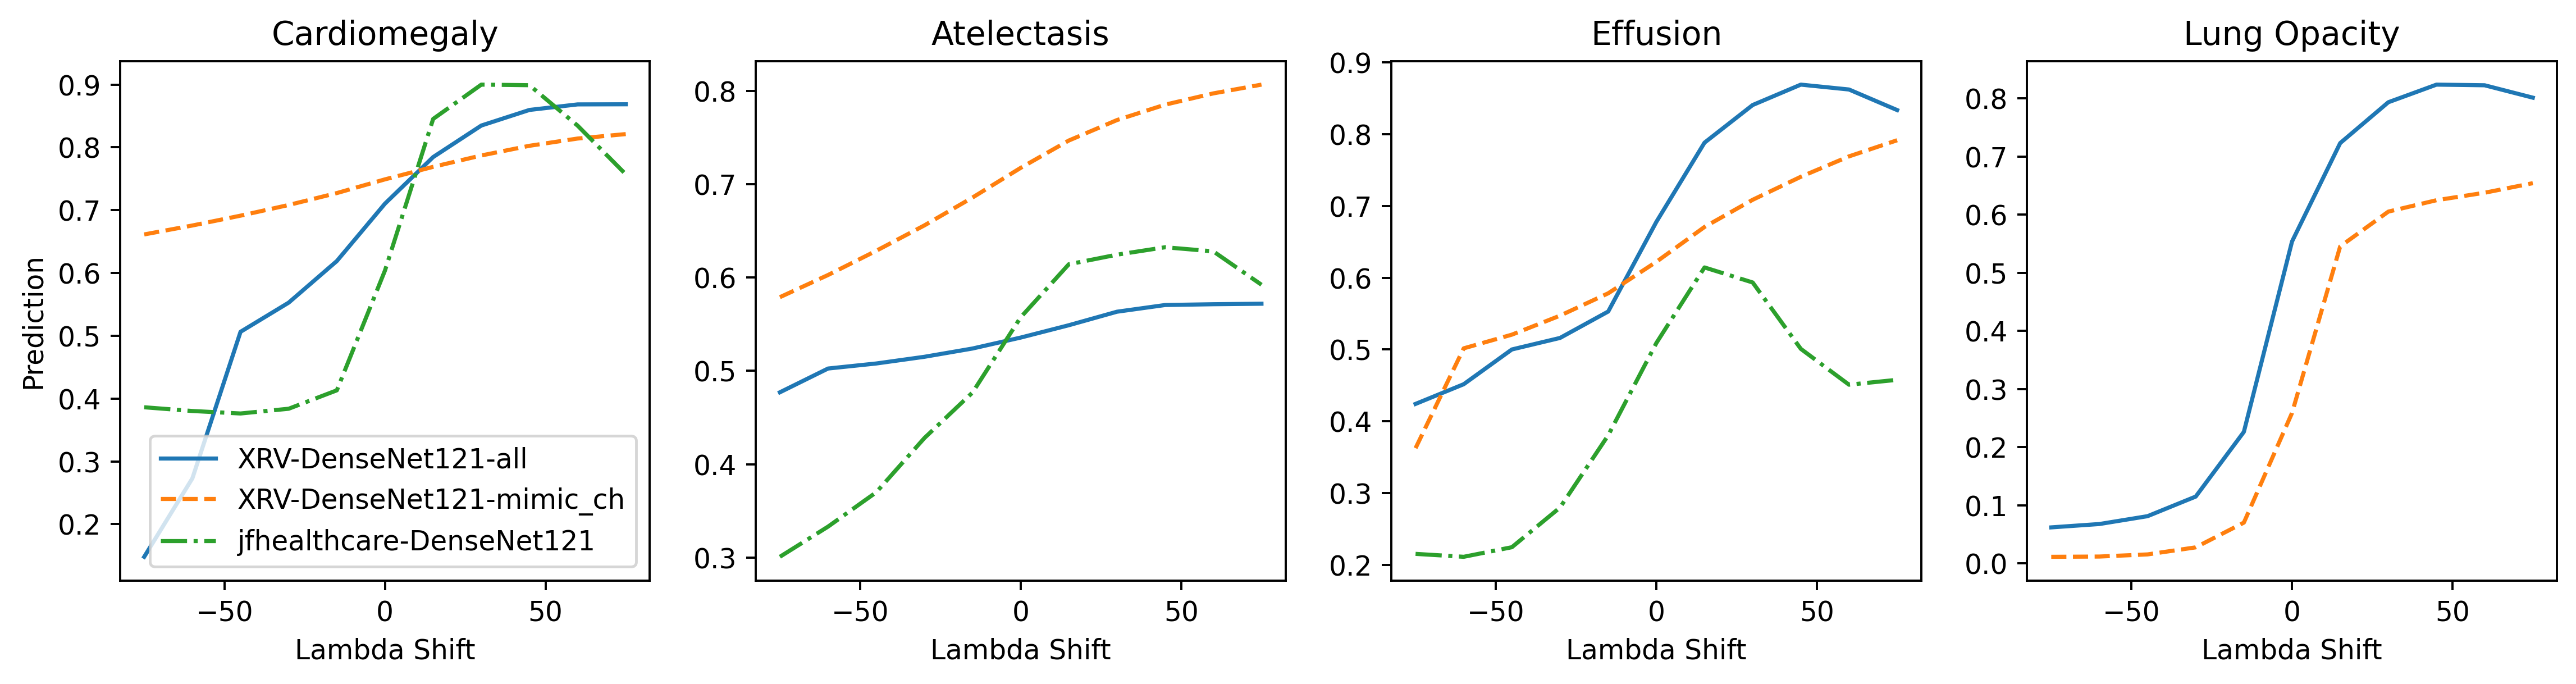

In [108]:
fig, ax = plt.subplots(1,len(for_eval), figsize=(16,3.5), dpi=350)
lines = ["-","--","-.",":"]
samples = [25,0,0,16]
for i, target in enumerate(for_eval):
    print(target)
    dwhere = np.where((dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
    sample = dmerge[dwhere[samples[i]]]
    image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

    for j, model in enumerate(models):
        if target in model.pathologies:
            params = attribution.compute_attribution(image.cuda(), "latentshift", 
                                                     model, target, ae=ae,
                                                     ret_params=True, 
                                                    fixrange=[-75,75])
            ax[i].plot(params["lambdas"],params["y"], label=str(model), ls=lines[j])
    if i == 0:
        ax[i].set_ylabel("Prediction");
        ax[i].legend()
    ax[i].set_xlabel("Lambda Shift");
    ax[i].set_title(target);
